In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://gist.githubusercontent.com/khoi/9dbc66e4c2ee841c56c1e390d40dc443/raw/d2914c3a7ba9144a5e7f89dc81bdd44d25c3fddc/titanic.csv")

In [3]:
df["Age"].fillna(df["Age"].mean(), inplace=True)

In [4]:
from sklearn.tree import DecisionTreeClassifier

X = df.drop(["Survived", "PassengerId", "Name", "Embarked", "Cabin", "Ticket"], axis=1)
X = pd.get_dummies(X, columns=['Sex'])

y = df["Survived"]

X.sample(5)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
13,3,39.000000,1,5,31.2750,0,1
832,3,29.699118,0,0,7.2292,0,1
122,2,32.500000,1,0,30.0708,0,1
128,3,29.699118,1,1,22.3583,1,0
28,3,29.699118,0,0,7.8792,1,0


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["Survived"])
print(X_train.shape)
print(X_test.shape)

(712, 7)
(179, 7)


## Decision Tree


In [6]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = tree_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("_________________________________")
print(classification_report(y_test, y_pred))

[[100  10]
 [ 24  45]]
_________________________________
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       110
           1       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



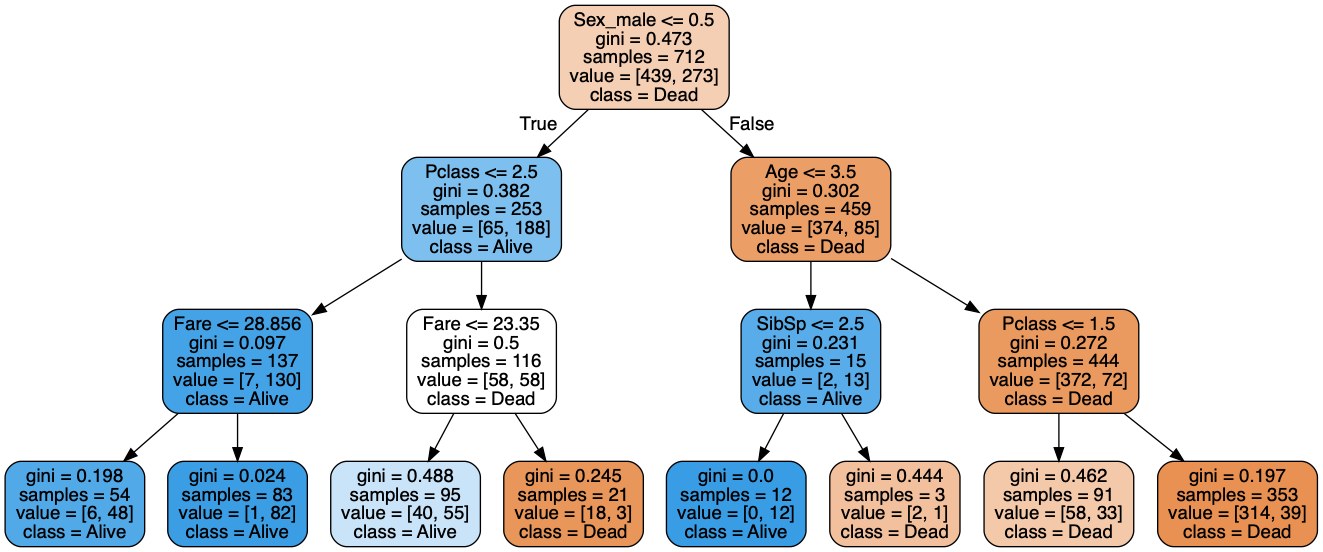

In [8]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image  

dot_data = export_graphviz(
            tree_clf,
            out_file=None,
            feature_names=X.columns,
            class_names=["Dead", "Alive"],
            rounded=True,
            filled=True
        )

graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_pdf("decision_tree.pdf")
Image(graph.create_png())

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [10]:
list(zip(X.columns, rnd_clf.feature_importances_))

[('Pclass', 0.08025957615401717),
 ('Age', 0.2727441520118964),
 ('SibSp', 0.04651051957328328),
 ('Parch', 0.033420885167562385),
 ('Fare', 0.2921509955349445),
 ('Sex_female', 0.1077866271785913),
 ('Sex_male', 0.1671272443797049)]

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rnd_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("_________________________________")
print(classification_report(y_test, y_pred))

[[94 16]
 [19 50]]
_________________________________
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



## Cross validations

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    cloned_clf = clone(rnd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = (y_train.iloc[train_index])
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = (y_train.iloc[test_index])

    cloned_clf.fit(X_train_folds, y_train_folds)
    y_pred = cloned_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.7902097902097902
0.7552447552447552
0.8111888111888111
0.8098591549295775
0.7943262411347518


In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(rnd_clf, X_train, y_train, cv=5, n_jobs=-1)

array([0.79020979, 0.74825175, 0.82517483, 0.83098592, 0.80141844])

## Grid Search

In [28]:
from sklearn.model_selection import GridSearchCV

max_depths = [10, 20, 30]
min_samples_leafs = [10, 20, 30]
min_samples_splits = [10, 20, 30]

param_grid = {
    'max_depth': max_depths,
    'min_samples_leaf': min_samples_leafs,
    'min_samples_split': min_samples_splits
}

decision_tree_grid = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid, 
    scoring='f1', 
    verbose=10, 
    n_jobs=-1, 
    cv=5)

decision_tree_grid.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(decision_tree_grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = decision_tree_grid.cv_results_['mean_test_score']
stds = decision_tree_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, decision_tree_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, decision_tree_grid.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0165s.) Setting batch_size=24.
[Parallel(n_jobs=-1)]: Done  14 out of 135 | elapsed:    0.1s remaining:    1.0s


Best parameters set found on development set:

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}

Grid scores on development set:

0.737 (+/-0.082) for {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
0.738 (+/-0.082) for {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}
0.718 (+/-0.086) for {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 30}
0.704 (+/-0.126) for {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 10}
0.704 (+/-0.126) for {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 20}
0.708 (+/-0.112) for {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 30}
0.686 (+/-0.160) for {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 10}
0.686 (+/-0.160) for {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 20}
0.686 (+/-0.160) for {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 30}
0.737 (+/-0.082) for {'max_depth': 20, 'min_samples_leaf': 1

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
